In [1]:
import pandas as pd
from pandas import read_csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings("ignore")

os.chdir('/Users/xiaodanxu/Library/CloudStorage/GoogleDrive-arielinseu@gmail.com/My Drive/BEAM-CORE/BEAM Validation')

sns.set_theme(style="white", font_scale=1.4)

In [2]:
# load parameter and data for validation
meter_to_mile = 0.000621371
percent_of_samples = 0.1
mps_to_mph = 2.23694
scenario_name = 'SF2018'
modeled_vmt = read_csv('sample output/SFB2018/0.linkstats.csv.gz', low_memory=False)
observed_vmt = read_csv('data for validation/SF/VMT/sf_hpms_inventory_clipped.csv', low_memory=False)
model_network = read_csv('sample output/SFB2018/beam_network_by_county.csv', low_memory=False)

modeled_vmt_by_hour = modeled_vmt.groupby('hour')[['volume']].sum()
modeled_vmt.head(5)
# print(modeled_vmt_by_hour)

,link,from,to,hour,length,freespeed,capacity,stat,volume,TruckVolume,HDTruckVolume,traveltime
0,144322,58094,58090,0,484.075,2.777778,300.0,AVG,0.0,0.0,0.0,174.267
1,144322,58094,58090,1,484.075,2.777778,300.0,AVG,0.0,0.0,0.0,174.267
2,144322,58094,58090,2,484.075,2.777778,300.0,AVG,0.0,0.0,0.0,174.267
3,144322,58094,58090,3,484.075,2.777778,300.0,AVG,0.0,0.0,0.0,174.267
4,144322,58094,58090,4,484.075,2.777778,300.0,AVG,0.0,0.0,0.0,174.267


In [3]:
print(observed_vmt.columns)
observed_vmt.loc[:, 'LN_MILES'] = meter_to_mile * observed_vmt.loc[:, 'Through_La'] * observed_vmt.loc[:, 'length (m)']
total_lane_mile_observed = observed_vmt['LN_MILES'].sum()
print(total_lane_mile_observed)
observed_vmt.head(5)

Index(['County_Cod', 'Route_ID', 'Begin_Poin', 'End_Point', 'Route_Numb',
       'F_System', 'Urban_Code', 'Through_La', 'Speed_Limi', 'AADT',
       'AADT_Singl', 'AADT_Combi', 'Shape_Leng', 'STATEFP', 'COUNTYNS',
       'GEOID', 'NAME', 'NAMELSAD', 'LSAD', 'CLASSFP', 'MTFCC', 'CSAFP',
       'CBSAFP', 'METDIVFP', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT',
       'INTPTLON', 'length (m)', 'straightdis', 'sinuosity'],
      dtype='object')
21582.60869534815


,County_Cod,Route_ID,Begin_Poin,End_Point,Route_Numb,F_System,Urban_Code,Through_La,Speed_Limi,AADT,...,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,length (m),straightdis,sinuosity,LN_MILES
0,1,ALA_OAK_HEGENBERGER RD_P,0.266,0.300,0,3,78904,2,0,50612,...,36084.0,A,1914242789,212979931,37.647138,-121.912488,57.200693,57.199469,1.000032,0.071086
1,1,SHS_013_P,4.000,4.008,13,2,78904,4,0,64000,...,36084.0,A,1914242789,212979931,37.647138,-121.912488,12.511048,12.511048,1.000000,0.031096
2,1,ALA_UNC_ALMADEN BLVD_P,0.928,0.976,0,5,78904,2,0,4361,...,36084.0,A,1914242789,212979931,37.647138,-121.912488,77.914498,77.914256,1.000005,0.096828
3,1,ALA_OAK_FOOTHILL BLVD_P,1.485,1.530,0,4,78904,2,0,3730,...,36084.0,A,1914242789,212979931,37.647138,-121.912488,73.199445,73.199445,1.000000,0.090968
4,1,ALA_CO_VIA ALAMITOS_P,0.845,1.072,0,5,78904,2,0,26785,...,36084.0,A,1914242789,212979931,37.647138,-121.912488,365.204626,365.204595,1.000000,0.453855


In [4]:
model_network = model_network.drop_duplicates(subset=['linkId'])
model_network.head(5)
model_network.loc[:, 'lane_mile'] = meter_to_mile * model_network.loc[:, 'linkLength'] * model_network.loc[:, 'numberOfLanes']
total_lane_mile_modeled = model_network['lane_mile'].sum()
print(total_lane_mile_modeled)

31368.254230903713


In [5]:
# filter modeled network
model_vmt_24_hour = modeled_vmt.loc[(modeled_vmt['hour'] <= 28) & (modeled_vmt['hour'] >= 5)]
model_vmt_24_hour.loc[model_vmt_24_hour['hour']>=24, 'hour'] -= 24
model_network.loc[:, 'fromNodeId'] = model_network.loc[:, 'fromNodeId'].astype(int)
model_network.loc[:, 'toNodeId'] = model_network.loc[:, 'toNodeId'].astype(int)
model_vmt_24_hour = pd.merge(model_vmt_24_hour, model_network, 
                                 left_on = ['link', 'from', 'to'],
                                 right_on = ['linkId', 'fromNodeId', 'toNodeId'], how = 'left')
print(len(model_vmt_24_hour))
model_vmt_24_hour.head(5)

4366368


,link,from,to,hour,length,freespeed,capacity,stat,volume,TruckVolume,...,linkModes,attributeOrigId,attributeOrigType,fromNodeId,toNodeId,GEOID,NAME,NAMELSAD,CLASSFP,lane_mile
0,144322,58094,58090,5,484.075,2.777778,300.0,AVG,0.0,0.0,...,car;walk;bike,NaN,NaN,58094.0,58090.0,6075.0,San Francisco,San Francisco County,H6,0.30079
1,144322,58094,58090,6,484.075,2.777778,300.0,AVG,0.0,0.0,...,car;walk;bike,NaN,NaN,58094.0,58090.0,6075.0,San Francisco,San Francisco County,H6,0.30079
2,144322,58094,58090,7,484.075,2.777778,300.0,AVG,0.0,0.0,...,car;walk;bike,NaN,NaN,58094.0,58090.0,6075.0,San Francisco,San Francisco County,H6,0.30079
3,144322,58094,58090,8,484.075,2.777778,300.0,AVG,0.0,0.0,...,car;walk;bike,NaN,NaN,58094.0,58090.0,6075.0,San Francisco,San Francisco County,H6,0.30079
4,144322,58094,58090,9,484.075,2.777778,300.0,AVG,0.0,0.0,...,car;walk;bike,NaN,NaN,58094.0,58090.0,6075.0,San Francisco,San Francisco County,H6,0.30079


In [6]:
model_vmt_24_hour.loc[:, 'lane_mile'] = meter_to_mile * model_vmt_24_hour.loc[:, 'numberOfLanes'] * model_vmt_24_hour.loc[:, 'linkLength'] / 24.0
total_lane_mile_with_cars = model_vmt_24_hour.loc[:, 'lane_mile'].sum()
print(total_lane_mile_with_cars)

31368.25423090368


10.0


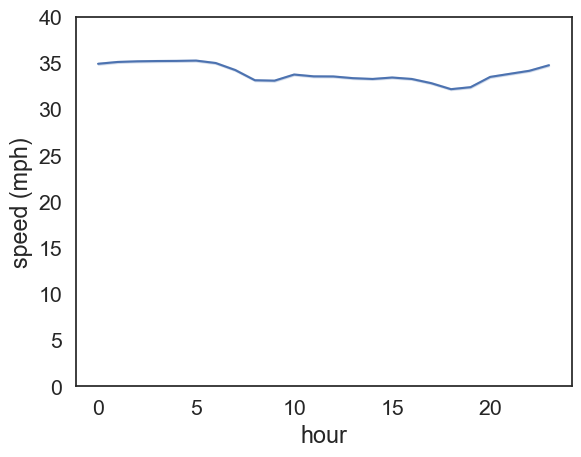

In [7]:

demand_scaling = 1/percent_of_samples
print(demand_scaling)
model_vmt_24_hour.loc[:, 'VMT'] = demand_scaling * meter_to_mile * model_vmt_24_hour.loc[:, 'linkLength'] * model_vmt_24_hour.loc[:, 'volume']
# model_vmt_24_hour.loc[:, 'travel_time (hr)'] = model_vmt_24_hour.loc[:, 'linkLength'] /3600

model_vmt_24_hour.loc[:, 'speed'] = model_vmt_24_hour.loc[:, 'linkLength'] / model_vmt_24_hour.loc[:, 'traveltime'] 
model_vmt_24_hour.loc[:, 'speed (mph)'] = mps_to_mph * model_vmt_24_hour.loc[:, 'speed']
model_vmt_24_hour.loc[:, 'volume'] *= demand_scaling
sns.lineplot(x = 'hour', y = 'speed (mph)', data = model_vmt_24_hour, ci = 95)
plt.ylim([0, 40])
plt.savefig('plot/' + scenario_name + '/modeled_speed_for_all_links.png', dpi = 200)
plt.show()


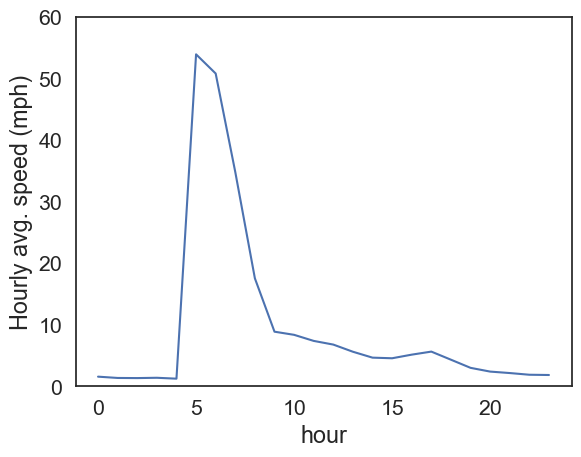

In [8]:
# SUMMARIZE HOURLY SPEED
model_vmt_24_hour.loc[:, 'VMT'] =  meter_to_mile * model_vmt_24_hour.loc[:, 'linkLength'] * model_vmt_24_hour.loc[:, 'volume']
model_vmt_24_hour.loc[:, 'VHT'] =  model_vmt_24_hour.loc[:, 'traveltime'] * model_vmt_24_hour.loc[:, 'volume'] / 3600.0
model_avg_speed = model_vmt_24_hour.groupby('hour')[['VMT','VHT']].sum()
model_avg_speed = model_avg_speed.reset_index()
model_avg_speed.loc[:, 'speed'] = model_avg_speed.loc[:, 'VMT'] / model_avg_speed.loc[:, 'VHT']
model_avg_speed.to_csv('sample output/SFB2018/avg_speed_whole_network.csv', sep = ',', index = False)
sns.lineplot(x = 'hour', y = 'speed', data = model_avg_speed, ci = None)
plt.ylim([0, 60])
plt.ylabel('Hourly avg. speed (mph)')
plt.savefig('plot/' + scenario_name + '/avg_speed_for_all_links.png', dpi = 200)
plt.show()

In [9]:
# create 24 pivot table for speed and volume
print(model_vmt_24_hour.columns)
speed_by_hour = pd.pivot_table(model_vmt_24_hour, values='speed (mph)', 
                               index=['linkId', 'fromNodeId', 'toNodeId', 'attributeOrigType'],
                    columns=['hour'])
speed_by_hour.columns = ['speed_' + str(i+1) for i in range(24)]
speed_by_hour = speed_by_hour.reset_index()
# print(speed_by_hour.head(5))

volume_by_hour = pd.pivot_table(model_vmt_24_hour, values='volume', 
                               index=['linkId', 'fromNodeId', 'toNodeId', 'attributeOrigType'],
                    columns=['hour'])
volume_by_hour.columns = ['volume_' + str(i+1) for i in range(24)]
volume_by_hour = volume_by_hour.reset_index()

combined_metric_by_hour = pd.merge(speed_by_hour, volume_by_hour, 
                                   on = ['linkId', 'fromNodeId', 'toNodeId', 'attributeOrigType'],
                                    how = 'outer')
combined_metric_by_hour.head(5)
combined_metric_by_hour.to_csv('sample output/SFB2018/processed_linkstats.csv', 
                               sep = ',', index = False)

Index(['link', 'from', 'to', 'hour', 'length', 'freespeed', 'capacity', 'stat',
       'volume', 'TruckVolume', 'HDTruckVolume', 'traveltime', 'Unnamed: 0',
       'linkId', 'linkLength', 'linkFreeSpeed', 'linkCapacity',
       'numberOfLanes', 'linkModes', 'attributeOrigId', 'attributeOrigType',
       'fromNodeId', 'toNodeId', 'GEOID', 'NAME', 'NAMELSAD', 'CLASSFP',
       'lane_mile', 'VMT', 'speed', 'speed (mph)', 'VHT'],
      dtype='object')


In [10]:
observed_vmt.loc[:, 'DVMT'] = meter_to_mile * observed_vmt.loc[:, 'AADT'] * observed_vmt.loc[:, 'length (m)']
observed_vmt.loc[:, 'DTRKVMT'] = meter_to_mile * (observed_vmt.loc[:, 'AADT_Singl']  + observed_vmt.loc[:, 'AADT_Combi']) * observed_vmt.loc[:, 'length (m)']
observed_vmt.loc[:, 'PVMT'] = observed_vmt.loc[:, 'DVMT'] - observed_vmt.loc[:, 'DTRKVMT']

In [11]:
# assign roadway classification to modeled network, 
# ref: https://wiki.openstreetmap.org/wiki/User:UltimateRiff/HFCS
modeled_roadtype = model_vmt_24_hour.attributeOrigType.unique()
modeled_roadtype_lookup = {'tertiary': 'Minor collector',
                           'trunk_link': 'Freeway and major arterial',
                           'residential': 'Local',
                           'track': 'Local',
                           'footway': 'Local',
                           'motorway': 'Freeway and major arterial',
                           'secondary': 'Major collector',
                           'unclassified': 'Local',
                           'path': 'Local',
                           'secondary_link': 'Major collector',
                           'primary': 'Minor arterial',
                           'motorway_link': 'Freeway and major arterial',
                           'primary_link': 'Minor arterial',
                           'trunk': 'Freeway and major arterial',
                           'pedestrian': 'Local',
                           'tertiary_link': 'Minor collector',
                           'cycleway': 'Local',
                           np.nan: 'Local',
                           'steps': 'Local',
                           'living_street': 'Local', 
                           'bus_stop': 'Local',
                           'corridor': 'Local', 
                           'road': 'Local',
                           'bridleway': 'Local'}

observed_roadtype_lookup = {1: 'Freeway and major arterial',
                            2: 'Freeway and major arterial',
                            3: 'Freeway and major arterial',
                            4: 'Minor arterial',
                            5: 'Major collector',
                            6: 'Minor collector',
                            7: 'Local'}
model_vmt_24_hour.loc[:, 'road_class'] = model_vmt_24_hour.loc[:, 'attributeOrigType'].map(modeled_roadtype_lookup)
observed_vmt.loc[:, 'road_class'] = observed_vmt.loc[:, 'F_System'].map(observed_roadtype_lookup)
# print(modeled_roadtype)

In [12]:
# customize color

print(sns.color_palette("Set1").as_hex())
color_dict = {'Freeway and major arterial':'#377eb8',
                  'Minor arterial': '#984ea3',
                  'Major collector': '#4daf4a', 
                  'Minor collector': '#ffcb05',
                   'Local': '#ff7f00'}

['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628', '#f781bf', '#999999']


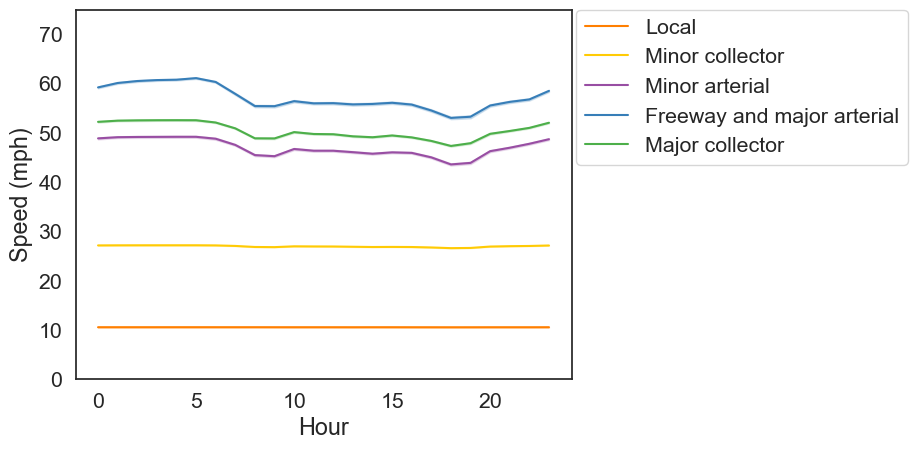

In [13]:
# model_vmt_24_hour = model_vmt_24_hour.sort_values('speed (mph)', ascending = False)
sns.lineplot(x = 'hour', y = 'speed (mph)', hue = 'road_class',
             data = model_vmt_24_hour, errorbar=('ci', 98), palette = color_dict)
plt.ylim([0, 75])
plt.xlabel('Hour')
plt.ylabel('Speed (mph)')
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.savefig('plot/' + scenario_name + '/modeled_speed_by_roadtype.png', dpi = 200, bbox_inches= 'tight')
plt.show()

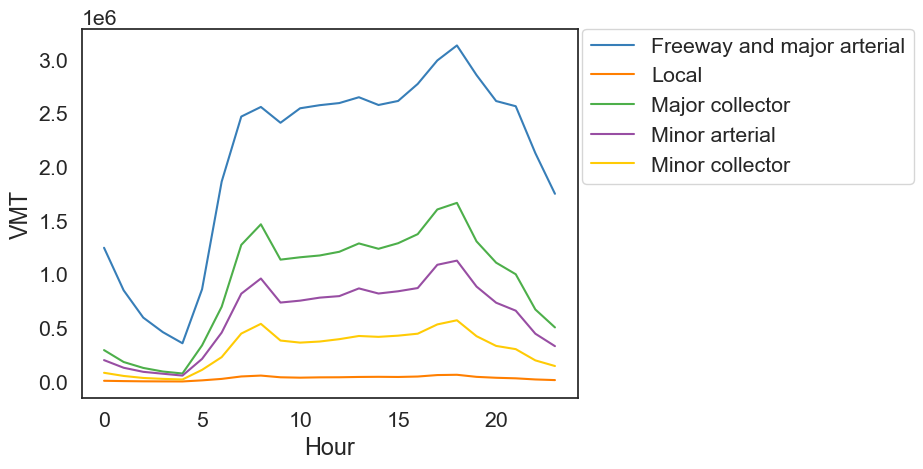

In [14]:
model_vmt_by_hour_roadtype = model_vmt_24_hour.groupby(['hour', 'road_class'])[['VMT']].sum()
model_vmt_by_hour_roadtype = model_vmt_by_hour_roadtype.reset_index()
# model_vmt_by_hour_roadtype = model_vmt_by_hour_roadtype.sort_values('VMT', ascending = False)
sns.lineplot(x = 'hour', y = 'VMT', hue = 'road_class',
             data = model_vmt_by_hour_roadtype, errorbar=('ci', None),
            palette = color_dict)
# plt.ylim([0, 75])
plt.xlabel('Hour')
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.savefig('plot/' + scenario_name + '/modeled_VMT_by_hour_roadtype.png', dpi = 200, bbox_inches= 'tight')
plt.show()

San Francisco


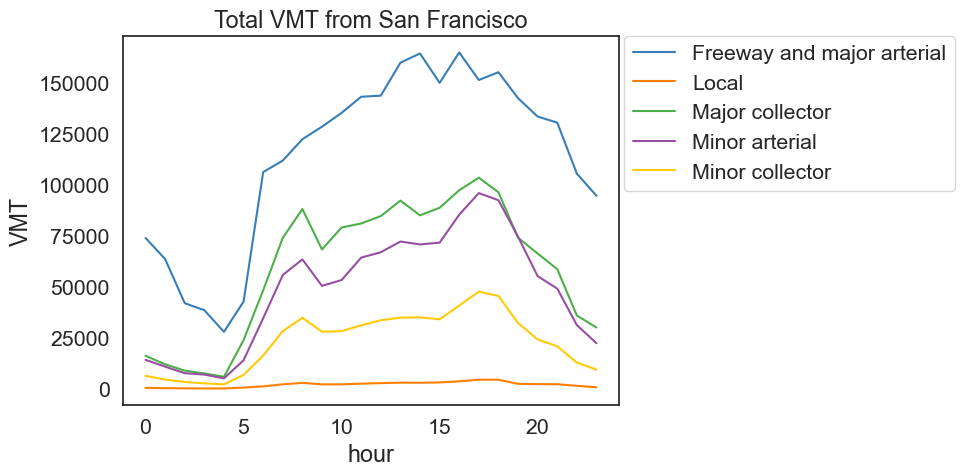

Contra Costa


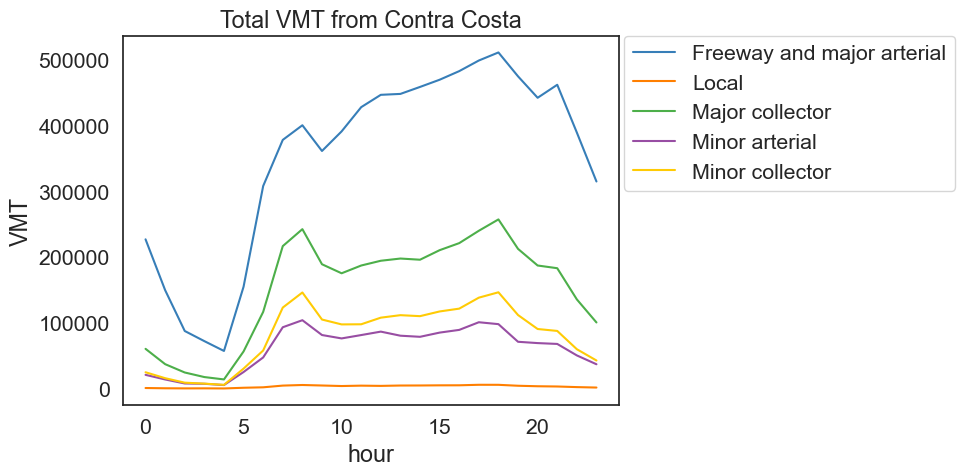

Sonoma


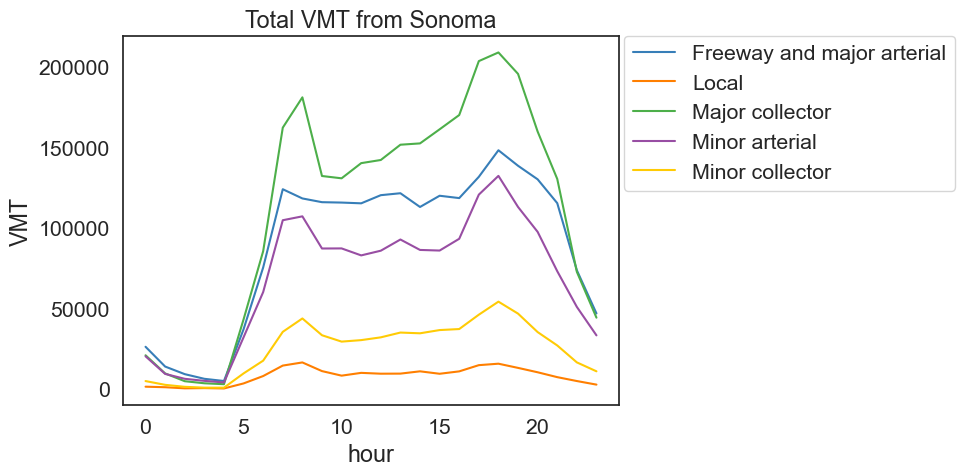

Santa Clara


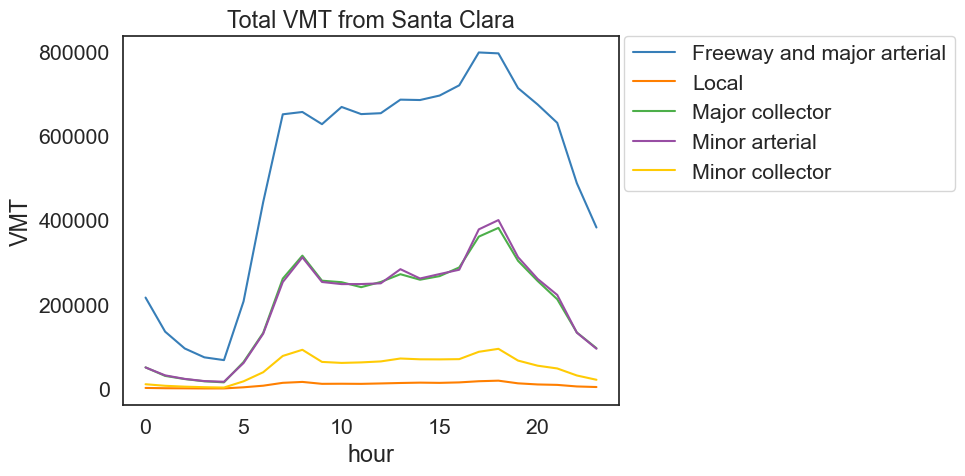

Santa Cruz


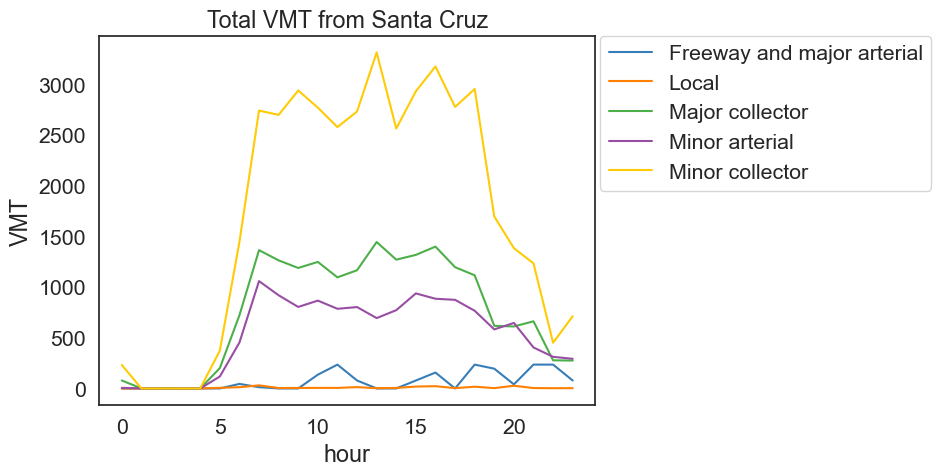

Napa


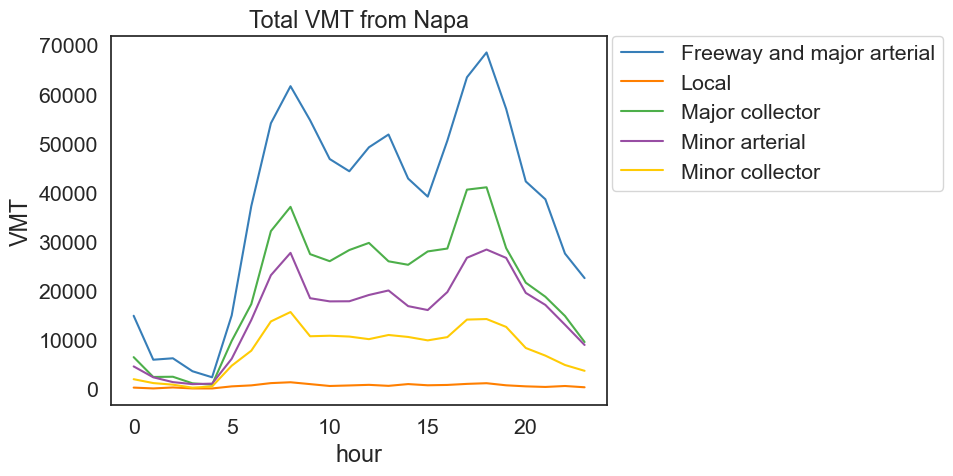

San Mateo


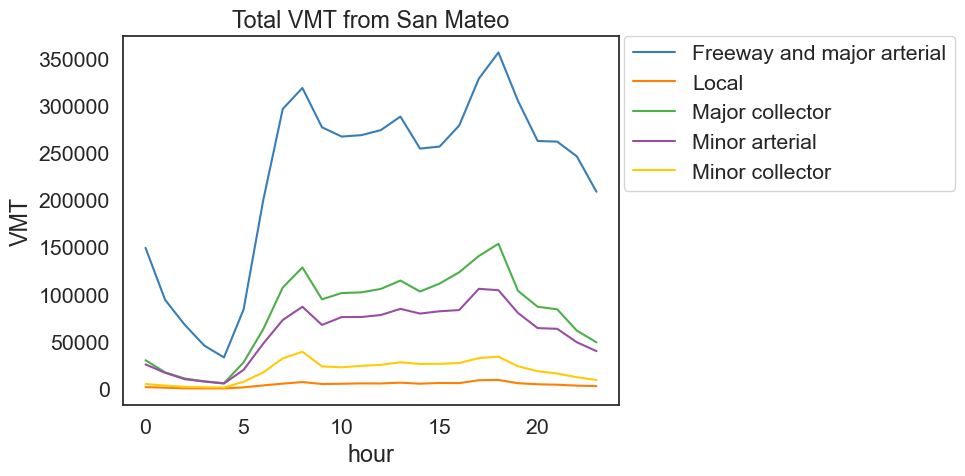

Alameda


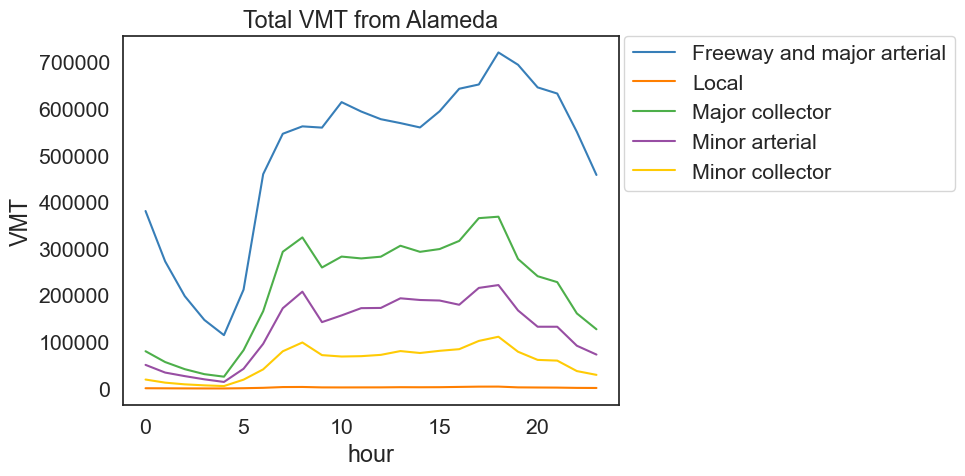

Solano


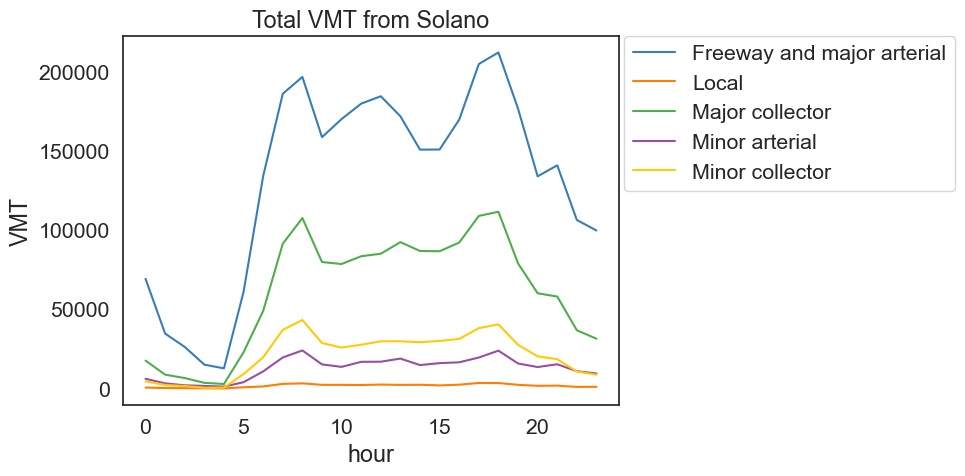

nan


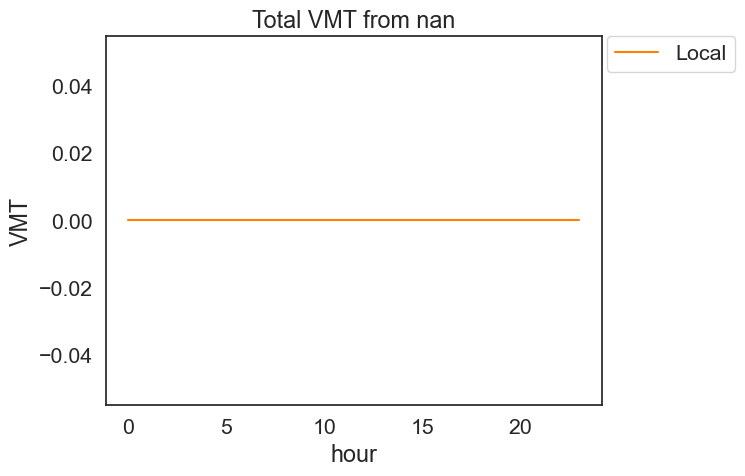

Marin


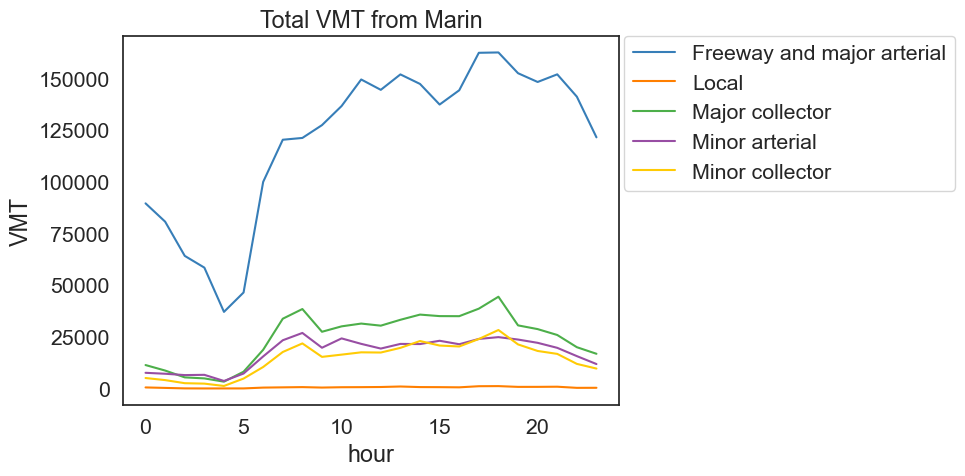

Yolo


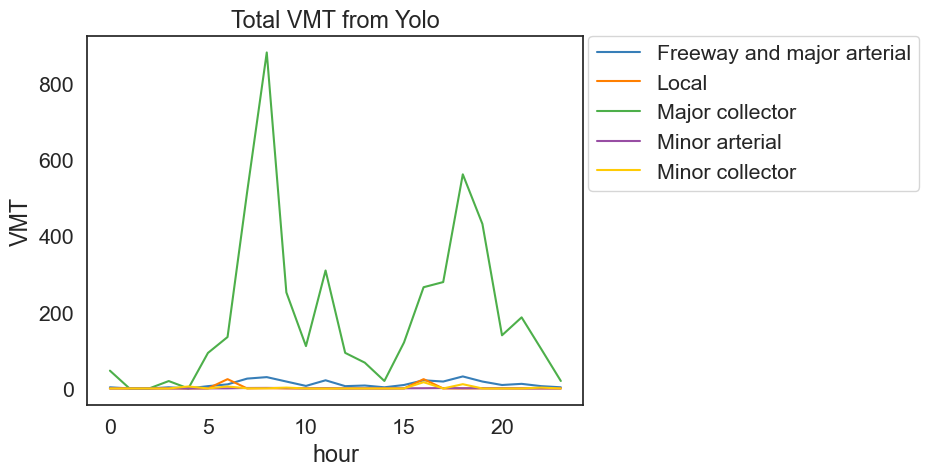

In [15]:
model_vmt_24_hour['NAME'] = model_vmt_24_hour['NAME'].astype(str)
model_vmt_24_hour = model_vmt_24_hour.loc[model_vmt_24_hour['NAME'] != '']
list_of_counties = model_vmt_24_hour.NAME.unique()
for county in list_of_counties:
    print(county)
#     if county == '':
#         continue
    model_vmt_by_county = model_vmt_24_hour.loc[model_vmt_24_hour['NAME'] == county]
    model_vmt_by_hour_county = model_vmt_by_county.groupby(['hour', 'road_class'])[['VMT']].sum()
    model_vmt_by_hour_county = model_vmt_by_hour_county.reset_index()
    sns.lineplot(x = 'hour', y = 'VMT', hue = 'road_class',
                 data = model_vmt_by_hour_county, errorbar=('ci', None),
            palette = color_dict)
    # plt.ylim([0, 75])
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    plt.title('Total VMT from ' + county)
    plt.savefig('plot/' + scenario_name + '/modeled_VMT_by_hour_' + county + '.png', dpi = 200, bbox_inches= 'tight')
    plt.show()

In [16]:
model_vmt_24_hour_nolocal = model_vmt_24_hour.loc[model_vmt_24_hour['road_class'] != 'Local']
model_vmt_by_county = model_vmt_24_hour_nolocal.groupby(['NAME'])[['VMT']].sum()
model_vmt_by_county = model_vmt_by_county.reset_index()
model_vmt_by_county

observed_vmt_by_county = observed_vmt.groupby('NAME')[['PVMT']].sum()
observed_vmt_by_county = observed_vmt_by_county.reset_index()
observed_vmt_by_county

,NAME,PVMT
0,Alameda,3.608136e+07
1,Contra Costa,2.217956e+07
2,Marin,7.095188e+06
3,Napa,2.589508e+06
4,San Francisco,7.958235e+06
5,San Mateo,1.703756e+07
6,Santa Clara,3.669650e+07
7,Santa Cruz,4.356828e+06
8,Solano,1.188175e+07
9,Sonoma,1.036721e+07


Observed    1.518869e+08
Modeled     9.430751e+07
dtype: float64


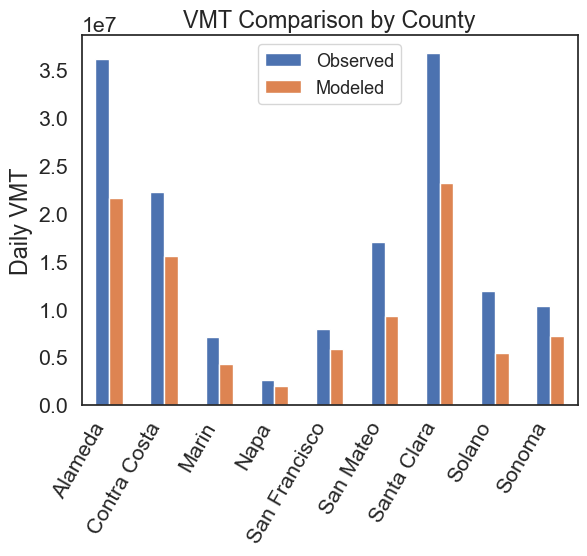

In [17]:
VMT_comparison = pd.merge(model_vmt_by_county, observed_vmt_by_county, 
                          on = 'NAME', how = 'left')
VMT_comparison = VMT_comparison.loc[:, ['NAME', 'PVMT', 'VMT']]
VMT_comparison.columns = ['County', 'Observed', 'Modeled']
VMT_comparison = \
VMT_comparison.loc[~VMT_comparison['County'].isin(['Santa Cruz', 'Yolo'])] 
print(VMT_comparison.loc[:, ['Observed', 'Modeled']].sum())

ax = VMT_comparison.plot.bar(x = 'County')
plt.xlabel('')
plt.xticks(rotation = 60)
plt.setp(ax.xaxis.get_majorticklabels(), ha='right')
plt.ylabel('Daily VMT')
plt.title('VMT Comparison by County')
plt.legend(fontsize = 13)
plt.savefig('plot/' + scenario_name + '/VMT_comparison_by_county.png', dpi = 200, bbox_inches = 'tight')
plt.show()

In [21]:
model_vmt_by_roadtype = model_vmt_24_hour.groupby(['road_class'])[['VMT']].sum()
model_vmt_by_roadtype = model_vmt_by_roadtype.reset_index()
observed_vmt_by_roadtype = observed_vmt.groupby(['road_class'])[['PVMT']].sum()
observed_vmt_by_roadtype = observed_vmt_by_roadtype.reset_index()
VMT_comparison_by_roadtype = pd.merge(observed_vmt_by_roadtype, 
                                      model_vmt_by_roadtype,  
                          on = 'road_class', how = 'right')
# VMT_comparison = VMT_comparison.loc[:, ['name', 'VMT', 'PVMT']]
VMT_comparison_by_roadtype.columns = ['Road_class', 'Observed_VMT', 'Modeled_VMT']
VMT_comparison_by_roadtype

,Road_class,Observed_VMT,Modeled_VMT
0,Freeway and major arterial,1.156645e+08,5.005602e+07
1,Local,NaN,7.779346e+05
2,Major collector,1.584947e+07,2.228865e+07
3,Minor arterial,2.619700e+07,1.475563e+07
4,Minor collector,2.687914e+04,7.287159e+06


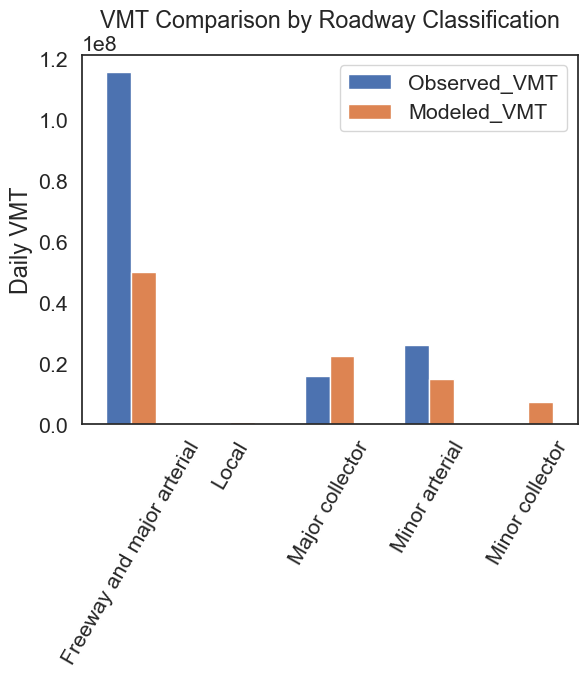

In [22]:
VMT_comparison_by_roadtype.plot.bar(x = 'Road_class')
plt.xlabel('')
plt.ylabel('Daily VMT')
plt.title('VMT Comparison by Roadway Classification')
plt.xticks(rotation = 60)
plt.savefig('plot/' + scenario_name + '/VMT_comparison_by_roadway_type.png', dpi = 200, bbox_inches = 'tight')
plt.show()

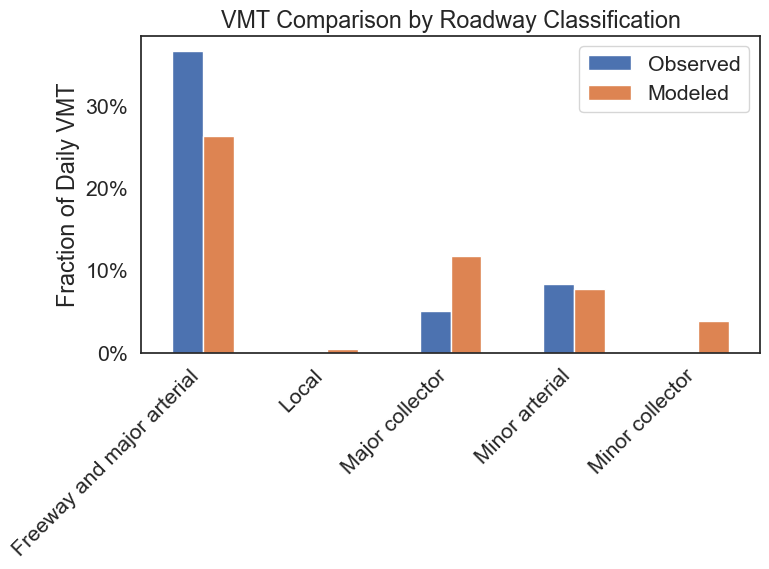

In [23]:
VMT_comparison_by_roadtype.loc[:, 'Modeled'] = \
VMT_comparison_by_roadtype.loc[:, 'Modeled_VMT'] / \
VMT_comparison_by_roadtype.loc[:, 'Modeled_VMT'].sum()
VMT_comparison_by_roadtype.loc[:, 'Observed'] = \
VMT_comparison_by_roadtype.loc[:, 'Observed_VMT'] / \
VMT_comparison_by_roadtype.loc[:, 'Observed_VMT'].sum()

percent_VMT_comparison_by_roadtype = \
VMT_comparison_by_roadtype.loc[:, ['Road_class', 'Observed', 'Modeled']]

import matplotlib.ticker as mtick
# plt.figure(figsize = (12,8))
ax = percent_VMT_comparison_by_roadtype.plot.bar(x = 'Road_class',figsize = (8,6))
# ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
plt.xlabel('')
plt.xticks(rotation = 45)
plt.setp(ax.xaxis.get_majorticklabels(), ha='right')
ax.set_yticklabels(['{:.0f}%'.format(x*100) for x in ax.get_yticks()]) 
# vals = ax.get_yticks()
# ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plt.ylabel('Fraction of Daily VMT')
plt.title('VMT Comparison by Roadway Classification')
plt.tight_layout()
plt.savefig('plot/' + scenario_name + '/percent_VMT_comparison_by_roadway_type.png', dpi = 200)
plt.show()

<Axes: xlabel='attributeOrigType'>

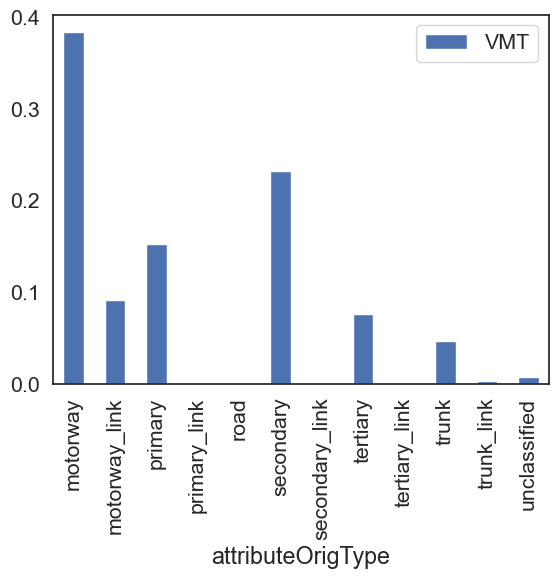

In [33]:
model_vmt_by_osmtype = model_vmt_24_hour.groupby(['attributeOrigType'])[['VMT']].sum()
model_vmt_by_osmtype.loc[:, 'VMT'] /= model_vmt_by_osmtype.loc[:, 'VMT'].sum()
model_vmt_by_osmtype.plot.bar()